In [1]:
import numpy as np
import matplotlib.pyplot as plt
from py_pol.mueller import Mueller, degrees
from py_pol.stokes import Stokes
from pyswarms.single.global_best import GlobalBestPSO

In [2]:
# Cargar datos
%cd D:\Documentos\Medidas experimentales\Polarimetro\Pol_Cal_22_02_01_Sin_Lente
data = np.load("Step_4a_2022-02-01.npz")
Iexp_A = data["Iexp"]
Angles_1_A = data["angles_1"]
Angles_2_A = data["angles_2"]
data = np.load("Step_4b_2022-02-01.npz")
Iexp_B = data["Iexp"]
Angles_1_B = data["angles_1"]
Angles_2_B = data["angles_2"]

D:\Documentos\Medidas experimentales\Polarimetro\Pol_Cal_22_02_01_Sin_Lente


In [23]:
# Constantes
P1_p1 = 0.976
P1_p2 = 0.076
P1_az = 110.6 * degrees
P2_p1 = 0.975
P2_p2 = 0.014
P2_az = 65.5 * degrees
S_az = 71 * degrees
S_el = 42.3 * degrees

In [57]:
def model(par):
    # S = Stokes().circular_light(intensity=2.4142)
    # Mp1 = Mueller().diattenuator_perfect(azimuth=-P1_az)
    # Mr2 = Mueller().quarter_waveplate(azimuth=-par[0])
    # Mrc = Mueller().quarter_waveplate(azimuth=45*degrees)
    Mp2 = Mueller().diattenuator_perfect(azimuth=-P2_az)
    Mp1 = Mueller().diattenuator_retarder_linear(
        p1=P1_p1,
        p2=P1_p2,
        R=par[3],
        azimuth=-P1_az)
    S = Stokes().general_azimuth_ellipticity(intensity=2.4142, azimuth=S_az, ellipticity=S_el)
    Mr2 = Mueller().retarder_azimuth_ellipticity(azimuth=-par[0], R=par[1], ellipticity=par[7])
    Mrc = Mueller().diattenuator_retarder_linear(azimuth=45*degrees+par[4], R=par[2], p1=par[5], p2=par[6])
    
    Mp1_rot = Mp1.rotate(angle=Angles_1_A, keep=True)
    Mr2_rot= Mr2.rotate(angle=-Angles_2_A, keep=True)
    
    Sf = Mp2 * Mr2_rot * Mrc * Mp1_rot * S
    Ia = Sf.parameters.intensity()
    
    Mr2_rot = Mr2.rotate(angle=-Angles_1_B, keep=True)
    Mp2_rot= Mp2.rotate(angle=Angles_2_B, keep=True)
    
    Sf = Mp2_rot * Mr2_rot * Mp1 * S
    Ib = Sf.parameters.intensity()
    
    return Ia, Ib

def error(par):
    Ia, Ib = model(par)
    Ea = (Ia - Iexp_A).flatten()
    Eb = (Ib - Iexp_B).flatten()
    return np.concatenate((Ea, Eb)) / (Ia.size + Ib.size)

def errorA(par):
    Ia, Ib = model(par)
    Ea = (Ia - Iexp_A).flatten()
    return Ea / (Ia.size)

def errorB(par):
    Ia, Ib = model(par)
    Eb = (Ib - Iexp_B).flatten()
    return Eb / (Ib.size)

def opt_func_PSO_ind(Transitions, fun, args):
    """Function needed as interface between PSO algorithm and error_global."""
    num_particles = Transitions.shape[0]  # number of particles
    error = [np.linalg.norm(fun(Transitions[i,:], *args)) for i in range(num_particles)]
    return error

def Ajustar(fun, title=""):
    # Ajuste
    bounds = ([0, 0, 0, 0, -10*degrees, 0.9, 0.9, -45*degrees], [180*degrees, 180*degrees, 180*degrees, 180*degrees, 10*degrees, 1, 1, 45*degrees])
    options_individual = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
    args = []

    optimizer = GlobalBestPSO(
                    n_particles=40, dimensions=len(bounds[0]), options=options_individual, bounds=bounds)
    cost, result = optimizer.optimize(opt_func_PSO_ind, iters=70, fun=fun, args=args)
    print("R2 az     R2 R      Rc R       P1 R     Rc offset       Rc p1       Rc p2   R2 el")
    print(title, result / degrees)
    # Representacion
    Ia, Ib = model(result)
    plt.figure(figsize=(15,8))
    plt.subplot(2,3,1)
    plt.imshow(Ia)
    plt.colorbar()
    plt.subplot(2,3,2)
    plt.imshow(Iexp_A)
    plt.colorbar()
    plt.subplot(2,3,3)
    plt.imshow(Iexp_A-Ia)
    plt.colorbar()
    plt.subplot(2,3,4)
    plt.imshow(Ib)
    plt.colorbar()
    plt.subplot(2,3,5)
    plt.imshow(Iexp_B)
    plt.colorbar()
    plt.subplot(2,3,6)
    plt.imshow(Iexp_B-Ib)
    plt.colorbar()
    plt.suptitle(title)

2022-02-09 17:18:43,965 - pyswarms.single.global_best - INFO - Optimize for 70 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|70/70, best_cost=0.00105
2022-02-09 17:19:42,647 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0010491039708255725, best pos: [1.60914177 1.79893441 1.61008331 2.02608915 0.16523878 0.92928254
 0.95662953 0.28867951]


R2 az     R2 R      Rc R       P1 R     Rc offset       Rc p1       Rc p2   R2 el
Both [ 92.19703203 103.0713495   92.25097807 116.08635698   9.46748471
  53.24396767  54.81083489  16.54011746]


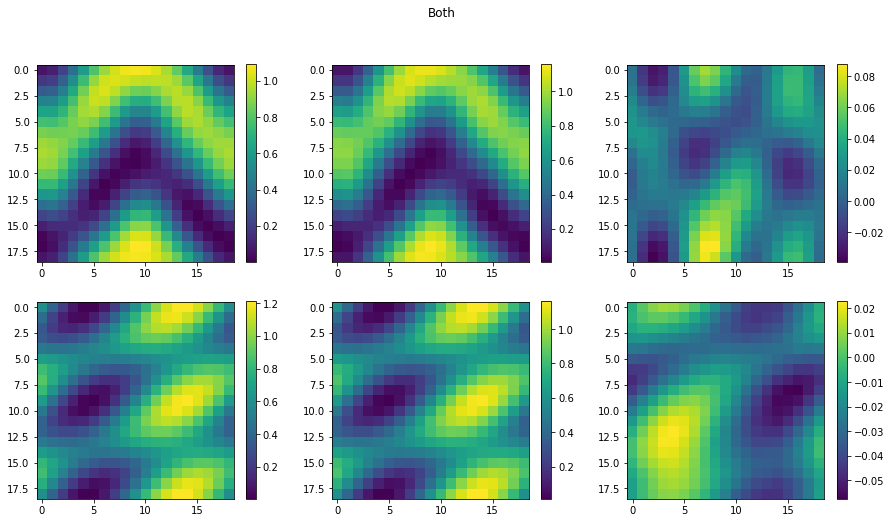

In [58]:
Ajustar(error, "Both")

2022-02-09 17:19:43,312 - pyswarms.single.global_best - INFO - Optimize for 70 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|70/70, best_cost=0.00105
2022-02-09 17:20:42,493 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0010487722691624364, best pos: [1.62130559 1.77074493 1.51038815 1.83230526 0.14014976 0.9567473
 0.96789206 0.31159466]


R2 az     R2 R      Rc R       P1 R     Rc offset       Rc p1       Rc p2   R2 el
Only A [ 92.89396766 101.45621115  86.53886645 104.98335813   8.02998966
  54.8175823   55.45613034  17.85305917]


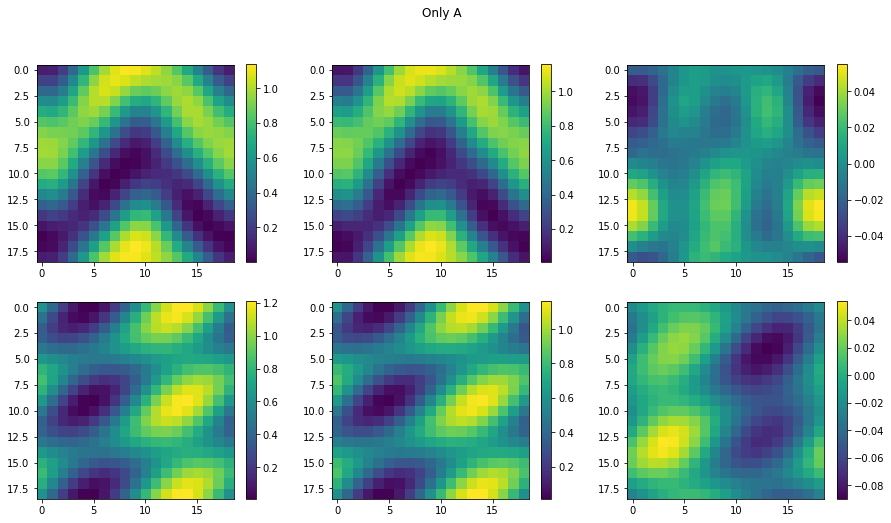

In [59]:
Ajustar(errorA, "Only A")

In [60]:
Ajustar(errorB, "Only B")

2022-02-09 17:20:43,171 - pyswarms.single.global_best - INFO - Optimize for 70 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|70/70, best_cost=0.00141
2022-02-09 17:21:42,515 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0014101027614621588, best pos: [ 1.60053659  1.80893192  0.74270068  1.88696397 -0.01441818  0.94738807
  0.98514031  0.28677713]


R2 az     R2 R      Rc R       P1 R     Rc offset       Rc p1       Rc p2   R2 el
Only B [ 91.70399135 103.64416419  42.55361442 108.11507156  -0.82610104
  54.2813378   56.44438178  16.43111919]
